In [1]:
!pip install git+https://github.com/ginihumer/segmentation-explanation-adapter.git

  Cloning https://github.com/ginihumer/segmentation-explanation-adapter.git to c:\users\christina\appdata\local\temp\pip-req-build-moi6wo05
  Resolved https://github.com/ginihumer/segmentation-explanation-adapter.git to commit babc87a43041cb61b310ee42aa9a23d4ae980d77
  Using cached tensorflow-2.8.0-cp38-cp38-win_amd64.whl (438.0 MB)
  Using cached Pillow-9.1.0-cp38-cp38-win_amd64.whl (3.3 MB)
  Using cached tensorflow_io_gcs_filesystem-0.25.0-cp38-cp38-win_amd64.whl (1.5 MB)
  Using cached numpy-1.22.3-cp38-cp38-win_amd64.whl (14.7 MB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached libclang-14.0.1-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached Werkzeug-2.1.2-py3-none-any.whl (224 kB)
  Created wheel for segmentation-explanation-adapter: filenam

  Running command git clone -q https://github.com/ginihumer/segmentation-explanation-adapter.git 'C:\Users\Christina\AppData\Local\Temp\pip-req-build-moi6wo05'


In [4]:
import segmentationadapter
from segmentationadapter import get_mask_for_class
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt

2.8.0


# 1. Load Segmentation Model

In [5]:
with tf.device("/cpu:0"):
    model = tf.keras.models.load_model("../models/mushroom_seg_model.h5")

In [6]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 384, 384, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 384, 384, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

# 2. Load and preprocess Image

In [7]:
image_path = "../data/TL2015PIC41336870.JPG"
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(384, 384))
array = tf.keras.preprocessing.image.img_to_array(img)
# We add a dimension to transform our array into a "batch"
preprocess_input = tf.keras.applications.vgg16.preprocess_input
array = preprocess_input(np.expand_dims(array, axis=0))

# 3. Generate mask that selects all pixels of a class (could also produce a custom mask)

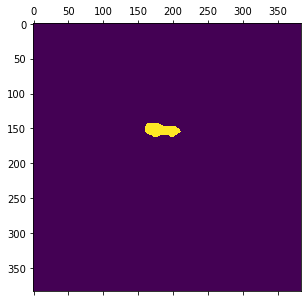

In [8]:
class_idx=2
with tf.device("/cpu:0"):
    mask = get_mask_for_class(model, array, class_idx=class_idx)
    plt.matshow(mask[0,:,:,0])

# 4. Transform the Segmentation Network to an Explainable Network that resembles the Architecture of a Classifier

In [9]:
with tf.device("/cpu:0"):
    explainable_model = segmentationadapter.get_explainable_model(model, mask=mask)
    explainable_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 384, 384, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 384, 384, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

# 5. Calculate Grad-CAM (or other explanation methods)

In [14]:
!pip install tf-explain
!pip install opencv-python

  Using cached opencv_python-4.5.5.64-cp36-abi3-win_amd64.whl (35.4 MB)


In [15]:
from tf_explain.core.grad_cam import GradCAM # this implementation of GradCAM does not use ReLU on the output to disregard negative values...

In [16]:
with tf.device("/cpu:0"):
    data = (array, None)
    explainer = GradCAM()
    grid = explainer.explain(
        data, explainable_model, class_index=class_idx, layer_name="final_conv", use_guided_grads=False, image_weight=0
    )

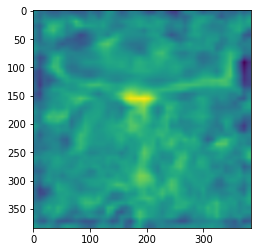

In [17]:
plt.imshow(grid)